In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Configure scanpy settings
sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Quality Control and Preprocessing

## Overview

This notebook performs comprehensive quality control (QC) and preprocessing on the Klebsiella pneumoniae lung macrophage dataset. The analysis includes:

1. **Data Loading**: Import the constructed AnnData object from notebook 1
2. **Quality Metrics**: Calculate and visualize cell and gene quality metrics
3. **Cell Filtering**: Remove low-quality cells and rarely expressed genes
4. **Doublet Detection**: Identify and remove potential doublets using Scrublet
5. **Normalization**: Apply standard scRNA-seq normalization procedures
6. **Feature Selection**: Identify highly variable genes for downstream analysis
7. **Dimensionality Reduction**: Perform PCA and UMAP for visualization
8. **Initial Clustering**: Generate preliminary clusters for QC assessment

## Data Context

The dataset contains purified alveolar macrophages (AM) and interstitial macrophages (IM) from control and Klebsiella pneumoniae-infected mice. The data has been pre-processed to remove non-macrophage cells and mitochondrial/ribosomal genes that could confound analysis.

## Data Loading and Initial Processing

### Load Dataset

In [2]:
# Load the AnnData object from notebook 1
adata = sc.read_h5ad('GSE184290_data.h5ad')

print(f"Loaded dataset: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"Conditions: {sorted(adata.obs['condition'].unique())}")

# Convert to float32 for memory efficiency
adata.X = adata.X.astype(np.float32)
print(f"Data type: {adata.X.dtype}")

Loaded dataset: 2,532 cells × 15,547 genes
Conditions: ['AM_Control', 'AM_KP+', 'AM_KP-', 'IM_Control', 'IM_KP+', 'IM_KP-']
Data type: float32


### Dataset Preprocessing Background

This dataset represents pre-purified macrophage populations isolated using FACS:

**Cell Type Identification:**
- **Interstitial Macrophages (IM)**: Cx3cr1+ SiglecF- cells
- **Alveolar Macrophages (AM)**: SiglecF+ cells

**Quality Control Context:**
The original researchers used the Immgen20 reference database to remove non-macrophage cells. Additionally, cells with >25% mitochondrial gene expression and ribosomal genes were filtered out during the "purification" step. This explains why mitochondrial and ribosomal gene percentages appear minimal in our QC metrics.

**Sample Groups:**
- AM_KP-: Alveolar macrophages from infected mice (uninfected cells)
- AM_KP+: Alveolar macrophages from infected mice (infected cells) 
- IM_KP-: Interstitial macrophages from infected mice (uninfected cells)
- IM_KP+: Interstitial macrophages from infected mice (infected cells)
- AM_Control: Alveolar macrophages from control mice
- IM_Control: Interstitial macrophages from control mice

## Quality Control Metrics

### Gene Annotation and QC Calculation

In [3]:
# Annotate mitochondrial and ribosomal genes for QC metrics
adata.var["mt"] = adata.var_names.str.startswith("Mt-")  # Mouse mitochondrial genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))  # Mouse ribosomal genes

# Calculate comprehensive QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)

print("QC metrics calculated:")
print(f"- Mitochondrial genes detected: {adata.var['mt'].sum()}")
print(f"- Ribosomal genes detected: {adata.var['ribo'].sum()}")
print(f"- QC columns added: n_genes_by_counts, total_counts, pct_counts_mt, pct_counts_ribo")

QC metrics calculated:
- Mitochondrial genes detected: 0
- Ribosomal genes detected: 109
- QC columns added: n_genes_by_counts, total_counts, pct_counts_mt, pct_counts_ribo


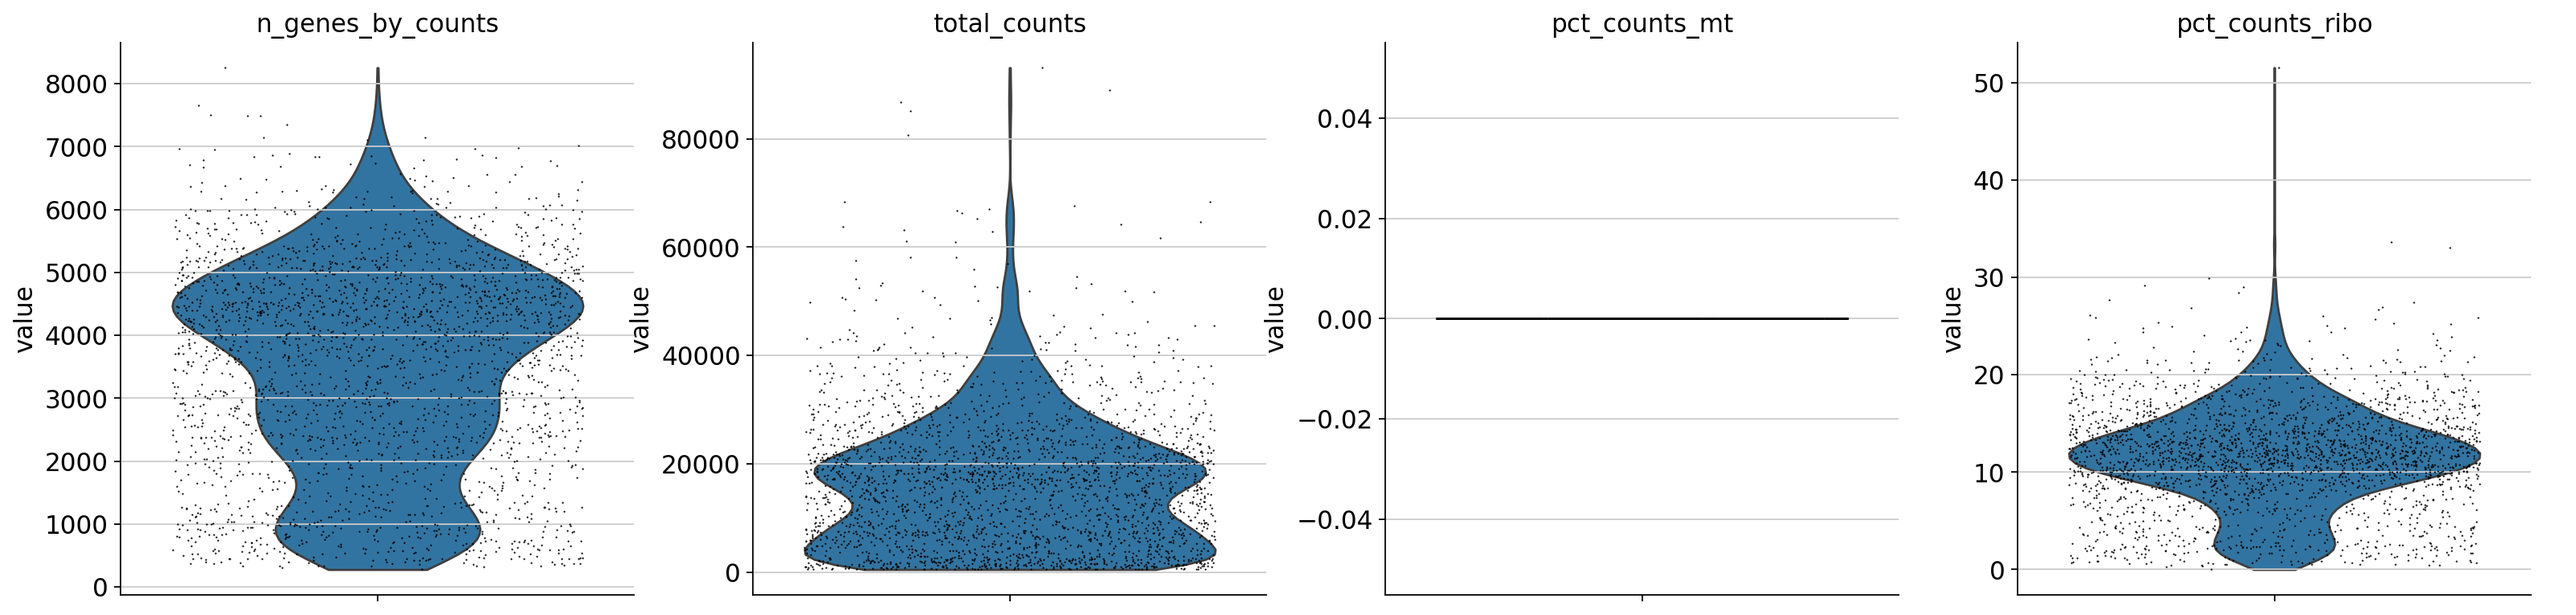

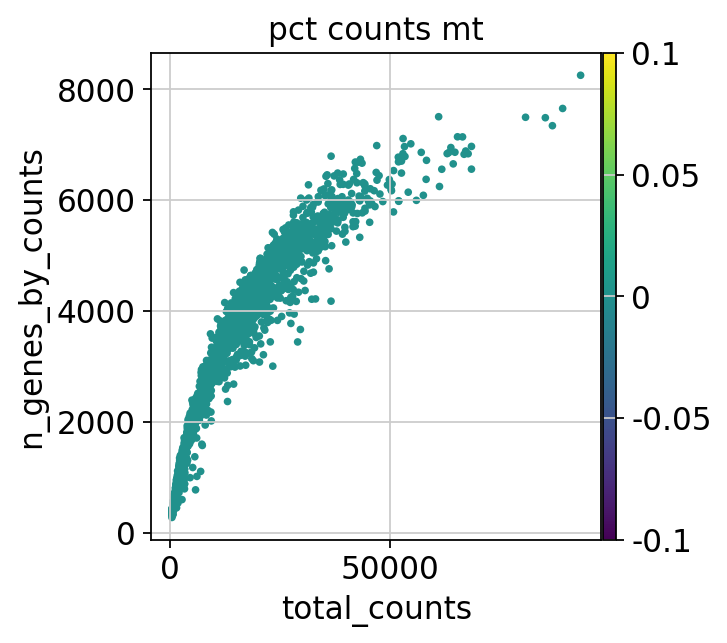

In [4]:
# Visualize overall QC metrics
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"], 
             jitter=0.4, multi_panel=True)

# Scatter plot showing relationship between total counts and gene counts
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### QC Observations

**Mitochondrial and Ribosomal Gene Removal:**

The QC plots confirm that mitochondrial and ribosomal genes have been largely removed from this dataset during preprocessing. This removal is a common practice in scRNA-seq analysis for several reasons:

**Mitochondrial genes removal rationale:**
- High mitochondrial gene expression indicates cellular stress, apoptosis, or poor cell quality
- Can confound biological signal with technical artifacts
- Cells with >25% mitochondrial expression were already filtered in the original study

**Ribosomal gene removal rationale:**
- Ribosomal proteins are highly expressed and can dominate variance in the dataset
- Their expression primarily reflects metabolic activity and cell cycle rather than cell identity
- Removing them helps focus analysis on biologically relevant transcriptional differences
- Prevents ribosomal expression from masking subtler cell type-specific signatures

This preprocessing step improves downstream analysis by reducing technical noise and enhancing the detection of biologically meaningful differences between macrophage populations and treatment conditions.

### QC Metrics by Experimental Condition

Experimental conditions:
  AM_Control: 422 cells
  AM_KP+: 422 cells
  AM_KP-: 422 cells
  IM_Control: 422 cells
  IM_KP+: 422 cells
  IM_KP-: 422 cells


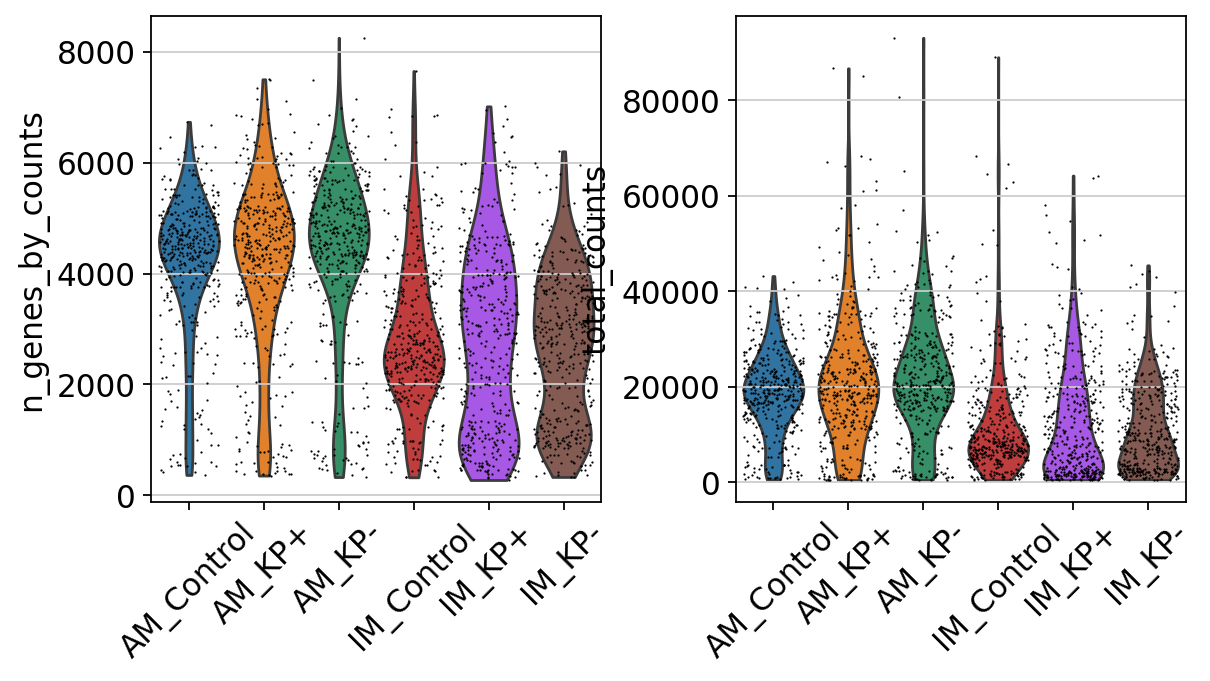

In [5]:
# Examine QC metrics stratified by experimental condition
print("Experimental conditions:")
for condition in sorted(adata.obs["condition"].unique()):
    count = (adata.obs["condition"] == condition).sum()
    print(f"  {condition}: {count:,} cells")

# Visualize QC metrics by condition
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    groupby='condition',
    jitter=0.4,
    multi_panel=True,
    rotation=45
)

### Cell and Gene Filtering Strategy

The QC visualizations show variation in gene counts and total counts across conditions. Each condition currently contains 422 cells. We'll apply conservative filtering thresholds based on the original study methodology:

**Filtering Rationale:**
- **Quality over quantity**: Better to retain high-quality cells than include questionable ones
- **Conservative approach**: Start permissive, can revisit thresholds later if needed
- **Study consistency**: Follow the original paper's methodology where possible

**Applied Filters:**
- Minimum 200 genes per cell (removes very low-quality cells)
- Genes expressed in minimum 3 cells (removes extremely rare genes)

In [6]:
# Apply basic filtering thresholds
print("Before filtering:")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Genes: {adata.n_vars:,}")

# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)  # Remove cells with < 200 genes
sc.pp.filter_genes(adata, min_cells=3)    # Remove genes expressed in < 3 cells

print("\nAfter filtering:")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Genes: {adata.n_vars:,}")

# Check condition distribution after filtering
print(f"\nCells per condition after filtering:")
for condition in sorted(adata.obs["condition"].unique()):
    count = (adata.obs["condition"] == condition).sum()
    print(f"  {condition}: {count:,} cells")

Before filtering:
  Cells: 2,532
  Genes: 15,547

After filtering:
  Cells: 2,532
  Genes: 13,646

Cells per condition after filtering:
  AM_Control: 422 cells
  AM_KP+: 422 cells
  AM_KP-: 422 cells
  IM_Control: 422 cells
  IM_KP+: 422 cells
  IM_KP-: 422 cells


## Doublet Detection

Doublets are artifacts where two cells are captured together and appear as a single cell with combined gene expression profiles. We use Scrublet to identify and remove potential doublets.

In [7]:
# Run Scrublet doublet detection per condition
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    sc.pp.scrublet(adata, batch_key="condition")

print("Doublet detection completed")
print(f"Doublet columns added: predicted_doublet, doublet_score")

# Show doublet summary
doublet_summary = adata.obs.groupby('condition')['predicted_doublet'].agg(['count', 'sum'])
doublet_summary['doublet_rate'] = doublet_summary['sum'] / doublet_summary['count'] * 100
print(f"\nDoublet detection summary:")
print(doublet_summary)

Doublet detection completed
Doublet columns added: predicted_doublet, doublet_score

Doublet detection summary:
            count  sum  doublet_rate
condition                           
AM_Control    422   47     11.137441
AM_KP+        422   27      6.398104
AM_KP-        422   41      9.715640
IM_Control    422    6      1.421801
IM_KP+        422    7      1.658768
IM_KP-        422    5      1.184834


## Normalization and Preprocessing

### Count Normalization and Log Transformation

In [8]:
# Save raw count data
adata.layers["counts"] = adata.X.copy()

# Normalize to median total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Apply log(x + 1) transformation
sc.pp.log1p(adata)

print("Normalization completed:")
print(f"- Raw counts saved in adata.layers['counts']")
print(f"- Normalized to {1e4:.0e} total counts per cell")
print(f"- Log(x + 1) transformation applied")
print(f"- Data range: {adata.X.min():.3f} to {adata.X.max():.3f}")

Normalization completed:
- Raw counts saved in adata.layers['counts']
- Normalized to 1e+04 total counts per cell
- Log(x + 1) transformation applied
- Data range: 0.000 to 8.915


### Highly Variable Gene Selection

The original study reported strong overlap between replicates within cell types, indicating minimal batch effects. Therefore, we can identify highly variable genes across the entire dataset without requiring batch correction.

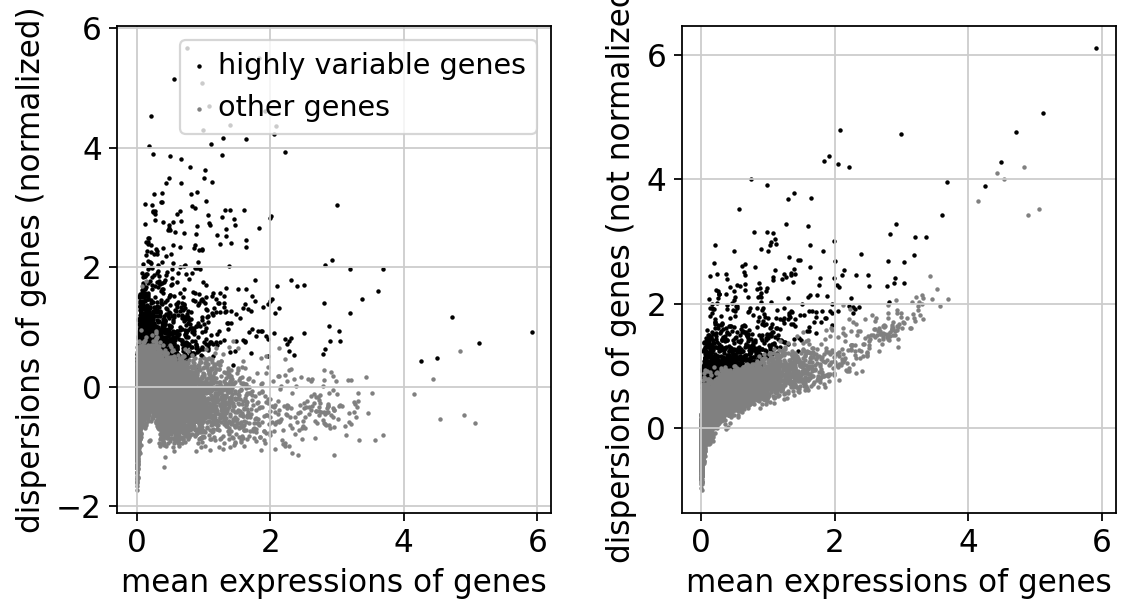

Highly variable genes identified: 2,000
Total genes: 13,646
Percentage highly variable: 14.7%


In [9]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="condition")

# Visualize highly variable genes
sc.pl.highly_variable_genes(adata)

print(f"Highly variable genes identified: {adata.var['highly_variable'].sum():,}")
print(f"Total genes: {adata.n_vars:,}")
print(f"Percentage highly variable: {adata.var['highly_variable'].sum() / adata.n_vars * 100:.1f}%")

The highly variable gene plot shows a good distribution with high-dispersion genes across moderate to high mean expression levels. This indicates we've captured informative genes while avoiding potential housekeeping genes that might have high expression but low dispersion.

## Dimensionality Reduction and Visualization

### Principal Component Analysis

PCA reduces dimensionality while preserving the main axes of variation in the data. We'll examine the contribution of principal components to determine how many to use for downstream analysis.

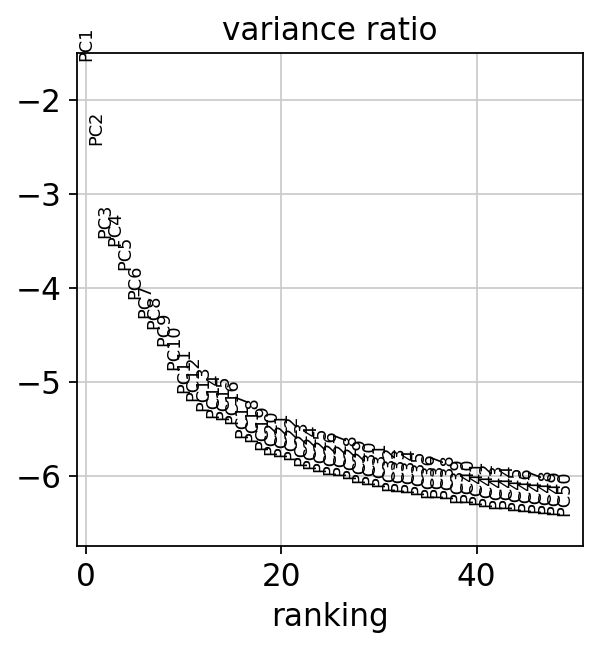

PCA completed using 2,000 highly variable genes
Variance explained by first 10 PCs: 0.432
Variance explained by first 40 PCs: 0.522


In [10]:
# Perform PCA on highly variable genes
sc.tl.pca(adata, svd_solver='arpack')

# Visualize PCA variance contribution
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

print(f"PCA completed using {adata.var['highly_variable'].sum():,} highly variable genes")
print(f"Variance explained by first 10 PCs: {adata.uns['pca']['variance_ratio'][:10].sum():.3f}")
print(f"Variance explained by first 40 PCs: {adata.uns['pca']['variance_ratio'][:40].sum():.3f}")

### Neighborhood Graph and UMAP

Compute the neighborhood graph using PCA representation, then generate UMAP coordinates for visualization.

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


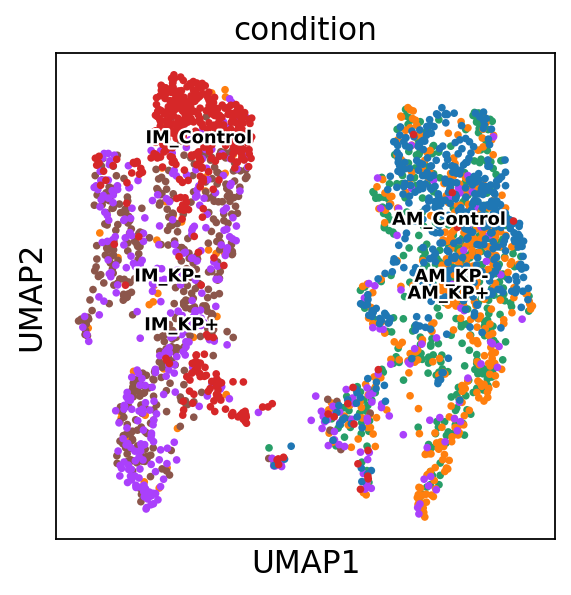

UMAP embedding completed
Neighborhood graph computed with 10 neighbors using 40 PCs


In [11]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP embedding
sc.tl.umap(adata)

# Visualize by experimental condition
sc.pl.umap(adata, color="condition", legend_loc='on data', 
           legend_fontoutline=2, legend_fontsize=8)

print("UMAP embedding completed")
print("Neighborhood graph computed with 10 neighbors using 40 PCs")

### UMAP Interpretation

The UMAP visualization demonstrates excellent data quality and processing:

**Biological Separation:**
- Clear separation between alveolar macrophages (AM) and interstitial macrophages (IM)
- This separation reflects genuine biological differences between these cell types

**Minimal Batch Effects:**
- Good mixing of treatment conditions within each macrophage subtype
- AM_Control, AM_KP+, and AM_KP- cells intermingle within the AM cluster
- IM_Control, IM_KP+, and IM_KP- cells intermingle within the IM cluster
- Confirms the absence of major technical batch effects

**Data Quality Indicators:**
- Absence of isolated outlier clusters suggests good cell quality
- Smooth transitions between similar conditions indicate biological continuity
- The structure supports downstream clustering and differential expression analysis

### Leiden Clustering

Perform initial clustering to help assess data quality and doublet detection results.

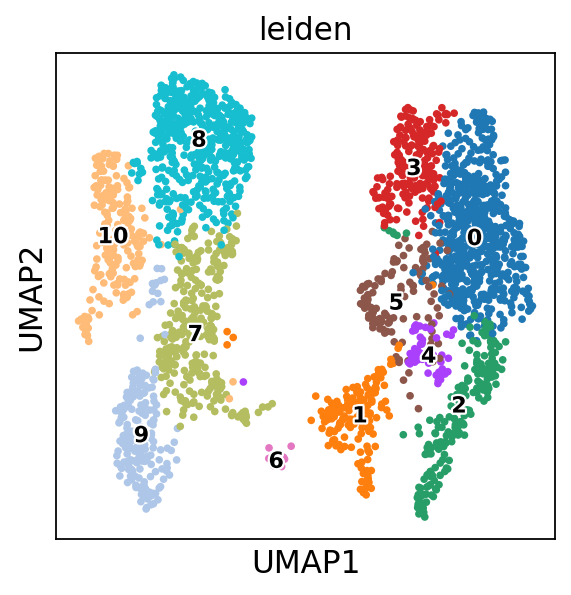

Leiden clustering completed
Number of clusters: 11
Cluster sizes:
  Cluster 0: 630 cells
  Cluster 1: 155 cells
  Cluster 2: 195 cells
  Cluster 3: 199 cells
  Cluster 4: 54 cells
  Cluster 5: 112 cells
  Cluster 6: 16 cells
  Cluster 7: 294 cells
  Cluster 8: 487 cells
  Cluster 9: 191 cells
  Cluster 10: 199 cells


In [12]:
# Perform Leiden clustering
sc.tl.leiden(adata, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

# Visualize clusters
sc.pl.umap(adata, color=["leiden"], legend_loc='on data', 
           legend_fontoutline=2, legend_fontsize=10)

print(f"Leiden clustering completed")
print(f"Number of clusters: {adata.obs['leiden'].nunique()}")
print(f"Cluster sizes:")
cluster_counts = adata.obs['leiden'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count:,} cells")

## Final Quality Assessment and Cell Filtering

### Doublet Removal and QC Validation

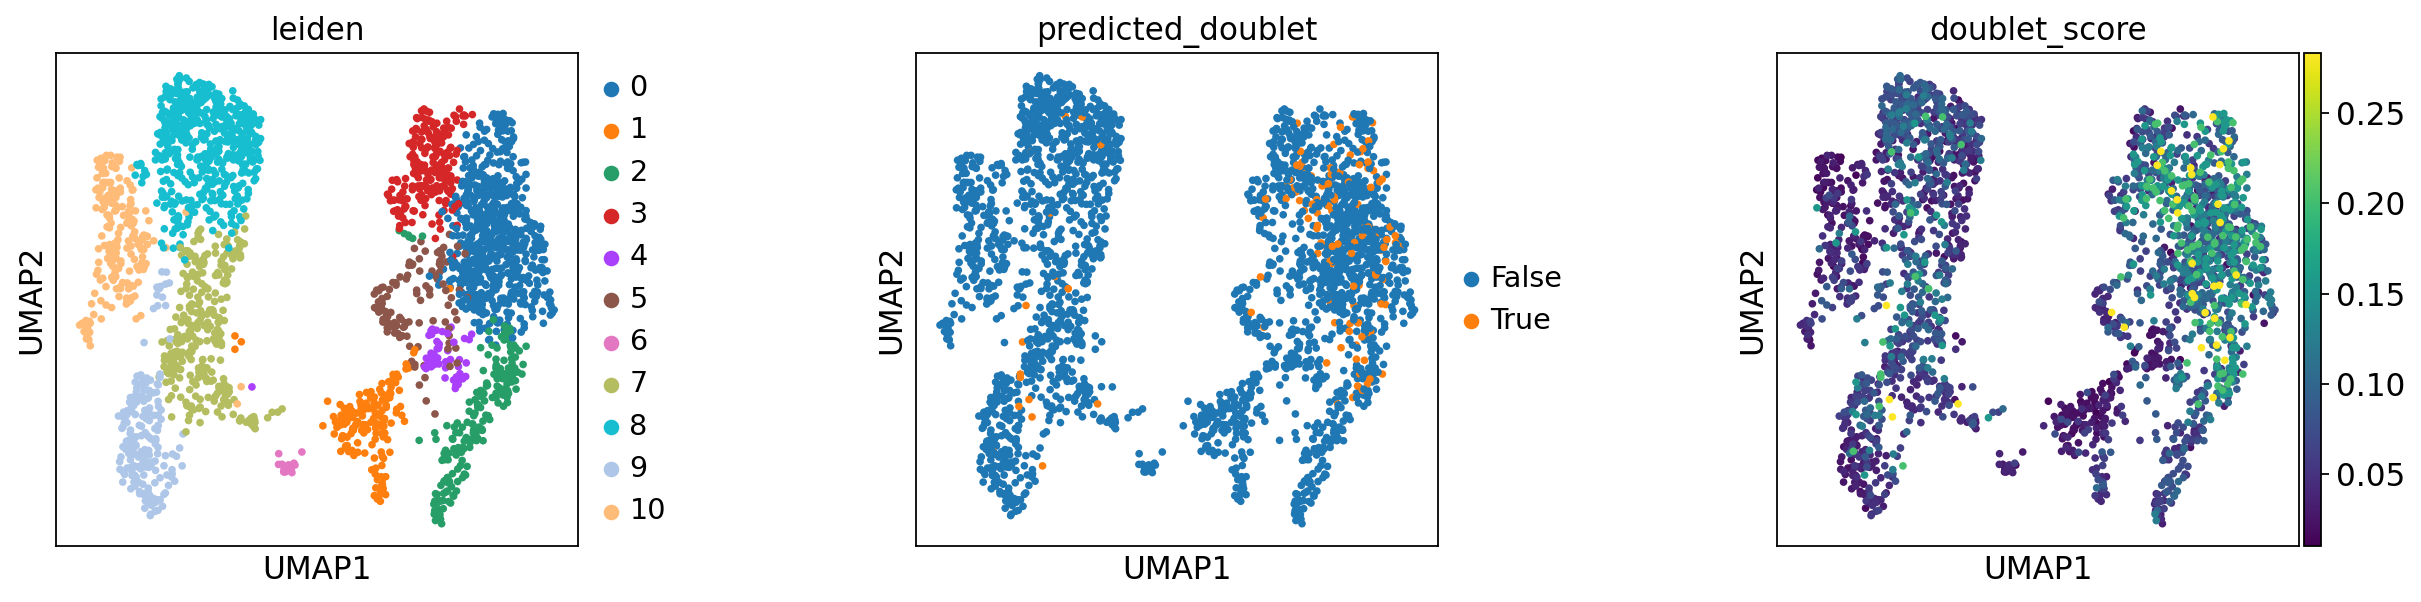

In [13]:
# Visualize doublets alongside clusters and QC metrics
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")

sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    wspace=0.5,
    ncols=3
)

Before doublet removal: 2,532 cells
After doublet removal: 2,399 cells
Doublets removed: 133 cells (5.3%)


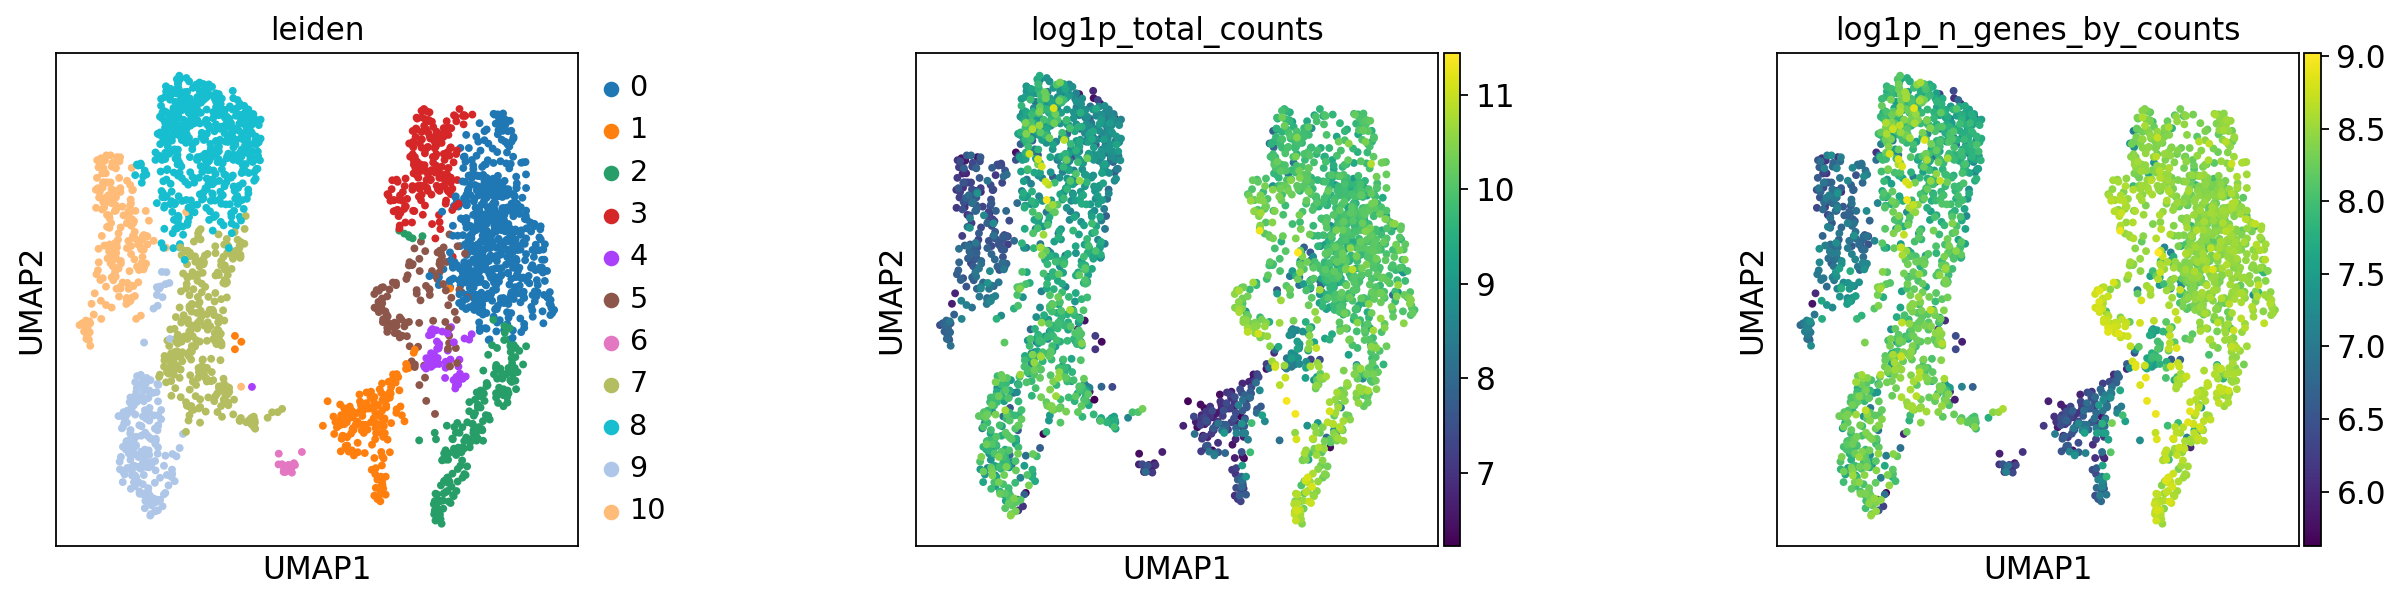

In [14]:
# Remove predicted doublets
print(f"Before doublet removal: {adata.n_obs:,} cells")

# Convert categorical to boolean and count doublets
doublets_mask = adata.obs["predicted_doublet"].astype(bool)
doublets_removed = doublets_mask.sum()

adata = adata[~doublets_mask].copy()

print(f"After doublet removal: {adata.n_obs:,} cells")
print(f"Doublets removed: {doublets_removed:,} cells ({doublets_removed/(adata.n_obs + doublets_removed)*100:.1f}%)")

# Final QC visualization
sc.pl.umap(
    adata, 
    color=["leiden", "log1p_total_counts", "log1p_n_genes_by_counts"], 
    wspace=0.5, 
    ncols=3
)

## Data Export

### Save Quality-Controlled Dataset

In [15]:
# Save the quality-controlled dataset
output_file = "QCed_GSE184290.h5ad"
adata.write(output_file)

print("Quality Control Summary:")
print(f"Final dataset: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"Highly variable genes: {adata.var['highly_variable'].sum():,}")
print(f"Experimental conditions: {len(adata.obs['condition'].unique())}")
print(f"Leiden clusters: {adata.obs['leiden'].nunique()}")

print(f"\nFinal cell counts per condition:")
final_counts = adata.obs['condition'].value_counts().sort_index()
for condition, count in final_counts.items():
    print(f"  {condition}: {count:,} cells")

print(f"\nProcessing completed successfully!")
print(f"Output saved to: {output_file}")
print(f"Ready for downstream clustering and differential expression analysis")

Quality Control Summary:
Final dataset: 2,399 cells × 13,646 genes
Highly variable genes: 2,000
Experimental conditions: 6
Leiden clusters: 11

Final cell counts per condition:
  AM_Control: 375 cells
  AM_KP+: 395 cells
  AM_KP-: 381 cells
  IM_Control: 416 cells
  IM_KP+: 415 cells
  IM_KP-: 417 cells

Processing completed successfully!
Output saved to: QCed_GSE184290.h5ad
Ready for downstream clustering and differential expression analysis
